In [1]:
from __future__ import print_function
import datetime
from functools import reduce
import os

import pandas as pd
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
#import psutil
#from multiprocessing import cpu_count

#p = psutil.Process(os.getpid())
#p.set_cpu_affinity(range(cpu_count()))
#print p.get_cpu_affinity()
os.system("taskset -p 0xff %d" % os.getpid())

0

In [3]:
startTime = datetime.datetime.now()

In [4]:
# Data collected from a spark query at CERN, in pandas pickle format
# CRAB jobs only have data after Oct. 2017
ws = pd.read_pickle("data/working_set_day.pkl.gz")
# spark returns lists, we want to use sets
ws['working_set_blocks'] = ws.apply(lambda x: set(x.working_set_blocks), 'columns')
ws['working_set'] = ws.apply(lambda x: set(x.working_set), 'columns')

In [5]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    blocksize = pd.read_csv("data/dbs_blocks.csv.gz", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a dictionary
blocksize = {v[0]:v[1] for v in blocksize}

In [6]:
# join the data tier definitions
datatiers = pd.read_csv('data/dbs_datatiers.csv').set_index('id')
ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values

In [7]:
date_index = np.arange(np.min(ws.day.values//86400), np.max(ws.day.values//86400)+1)
date_index_ts = np.array(list(datetime.date.fromtimestamp(day*86400) for day in date_index))

In [8]:
ws_filtered = ws[(ws.crab_job==True) & (ws.data_tier.str.contains('MINIAOD'))]

blocks_day = []
for i, day in enumerate(date_index):
    today = (ws_filtered.day==day*86400)
    blocks_day.append(reduce(lambda a,b: a.union(b), ws_filtered[today].working_set_blocks, set()))

print("Done assembling blocklists")

nrecords = np.zeros_like(date_index)
lifetimes = {
    '1w': 7,
    '1m': 30,
    '3m': 90,
    '6m': 120,
}
ws_size = {k: np.zeros_like(date_index) for k in lifetimes}
nrecalls = {k: np.zeros_like(date_index) for k in lifetimes}
recall_size = {k: np.zeros_like(date_index) for k in lifetimes}
previous = {k: set() for k in lifetimes}

for i, day in enumerate(date_index):
    nrecords[i] = ws_filtered[(ws_filtered.day==day*86400)].size
    for key in lifetimes:
        current = reduce(lambda a,b: a.union(b), blocks_day[max(0,i-lifetimes[key]):i+1], set())
        recall = current - previous[key]
        nrecalls[key][i] = len(recall)
        ws_size[key][i] = sum(blocksize[bid] for bid in current)
        recall_size[key][i] = sum(blocksize[bid] for bid in recall)
        previous[key] = current
    if i%30==0:
        print("Day ", i)

print("Done")

Done assembling blocklists
Day  0
Day  30
Day  60
Day  90
Day  120
Day  150
Day  180
Day  210
Day  240
Day  270
Day  300
Day  330
Day  360
Day  390
Day  420
Day  450
Day  480
Day  510
Day  540
Day  570
Day  600
Day  630
Day  660
Day  690
Day  720
Day  750
Done


In [9]:
print(list(blocksize.keys())[0:10])
print(list(blocksize.values())[0:10])

[16777216, 16777217, 16777218, 16777219, 16777220, 16777221, 16777222, 16777223, 16777224, 16777225]
[20329608129, 16116886675, 12668970442, 12449380625, 1270370651, 2724755002, 18445001, 18137333201, 16618896308, 20835210196]


<IPython.core.display.Javascript object>


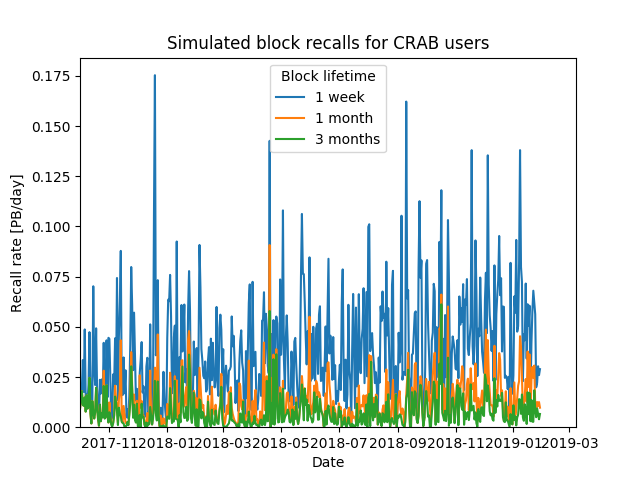

/home/recovery1/.local/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(736603.0, 737126.0)

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, recall_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, recall_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, recall_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Simulated block recalls for CRAB users')
ax.set_ylabel('Recall rate [PB/day]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

<IPython.core.display.Javascript object>


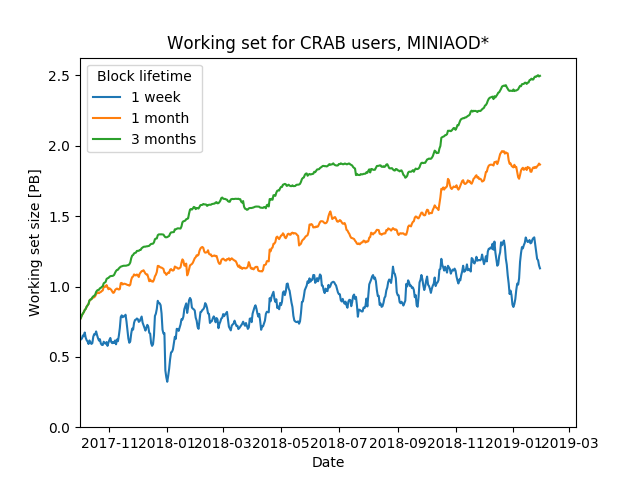

(736603.0, 737126.0)

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(date_index_ts, ws_size['1w']/1e15, label='1 week')
ax.plot(date_index_ts, ws_size['1m']/1e15, label='1 month')
ax.plot(date_index_ts, ws_size['3m']/1e15, label='3 months')
ax.legend(title='Block lifetime')
ax.set_title('Working set for CRAB users, MINIAOD*')
ax.set_ylabel('Working set size [PB]')
ax.set_xlabel('Date')
ax.set_ylim(0, None)
ax.set_xlim(datetime.date(2017,10,1), None)

In [12]:
recall_size['3m'].mean()/1e12

5.696515582485798

In [13]:
print(ws_filtered)

              day  d_data_tier_id  crab_job           input_campaign  \
29     1505779200           31223      True                 Run2017C   
36     1506556800           31224      True      PhaseIFall16MiniAOD   
41     1508025600           31223      True                 Run2016G   
43     1508630400           31223      True                 Run2016B   
51     1510099200           31223      True                 Run2016D   
53     1511136000           31223      True                 Run2017B   
59     1512777600           31223      True                 Run2017C   
64     1513900800           31224      True   RunIISpring16MiniAODv2   
65     1514505600           31223      True                 Run2017E   
69     1514937600           31224      True     RunIISummer17MiniAOD   
75     1515801600           31223      True                 Run2017F   
78     1516060800           31224      True   RunIISummer16MiniAODv2   
80     1516665600           31224      True   RunIISpring16MiniA

In [14]:
# block_dict is a dictionary that holds the lists of blocks
# for all of the days for which the lists are nonzero
# Keys: Day
# Values: List of Blocks that were accessed on that Day
block_dict = {}
i=0
for el in blocks_day:
    i=i+1
    if len(el)>0:
        block_dict[i] = el

print("Merging daily block lists into one block set")
block_list = []
for i in range(len(blocks_day)):
    block_list += blocks_day[i]
# block_set is a set of all unique blocks.
# This can be used to isolate properties of individual blocks
# (e.g. how many times a block is accessed)
block_set = set(block_list)
print("Block Set Created")

Merging daily block lists into one block set
Block Set Created


In [15]:
# Rounds down the number to the multiple specified by the divisor
def round_down(num, divisor):
    return num - (num % divisor)

# Counts the frequencies of the quantities of blocks reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for quantity of blocks such that
#                      the blocks are counted together (e.g. a bucket of 1000 means that a
#                      quantity of blocks less than 2000 would be counted as part of the
#                      1000 bucket because it is being rounded down)
def countBlockReuseFreq(threshold, bucket):
    block_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(len(b), bucket) in block_reuse_dict:
                block_reuse_dict[round_down(len(b), bucket)] += 1
            else:
                block_reuse_dict[round_down(len(b), bucket)] = 1
        except Exception as e:
            print("Empty Key: ", e)
            
    # Returns block_reuse_dict
    # Keys: Number of Blocks reused within the given threshold
    #       (organized by the given buckets)
    # Values: Frequencies of occurrence
    return block_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for bytes such that
#                      the bytes are counted together (e.g. a bucket of 1000 means that a
#                      size of less than 2000 bytes would be counted as part of the
#                      1000 byte bucket because it is being rounded down)
def countByteReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
            # Counting the number of bytes in b
            bSize = 0
            for block in b:
                bSize += blocksize[block]
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(bSize, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(bSize, bucket)] += 1
            else:
                byte_reuse_dict[round_down(bSize, bucket)] = 1
        except Exception as e:
            print("Empty Key: ", e)
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

# Counts the frequencies of the total number of bytes reused in an
# n day period (over all given time) where n = threshold
# Returns them as a fraction: (Reused Bytes for a given day) / (Bytes accessed for a given day) 
# Parameters: threshold - integer that determines the range of days (counted back from the given day)
#                         over which the blocks are counted
#             bucket - integer that determines "tolerance" for percentage of byte usage 
#                      such that the percentage of byte usage are counted together (e.g. 
#                      a bucket of 0.05 means that a size of less than 0.10 would be counted as
#                      part of the 0.05 percentage bucket because it is being rounded down)
def countByteFracReuseFreq(threshold, bucket):
    byte_reuse_dict = {}
    for day in block_dict:
        try:
            b = block_dict[day]
            i = day
            tSize = 0
            # Populating tSize with the bytes accessed in the given day
            for block in block_dict[day]:
                tSize += blocksize[block]
            for i in range(day+1, day+threshold+1):
                b = b.union(block_dict[i])
                # Counting the number of bytes accessed in the days within the threshold
                for block in block_dict[i]:
                    tSize += blocksize[block]
            # Counting the number of bytes in b
            bSize = 0
            for block in b:
                bSize += blocksize[block]
            percent = float(bSize)/float(tSize)
            # Rounds down to the bin and checks to see if such a bin exists in the dictionary
            if round_down(percent, bucket) in byte_reuse_dict:
                # Adding the number of bytes into the given block into the current bin
                byte_reuse_dict[round_down(percent, bucket)] += 1
            else:
                byte_reuse_dict[round_down(percent, bucket)] = 1
        except Exception as e:
            print("Empty Key: ", e)
    
    # Returns byte_reuse_dict
    # Keys: Bytes reused within the given threshold (organized by the given buckets)
    # Values: Frequencies of occurrence
    return byte_reuse_dict

In [16]:
print(list(countByteFracReuseFreq(1, 0.05).keys()))
print(list(countByteFracReuseFreq(1, 0.05).values()))
print(list(countByteFracReuseFreq(14, 0.05).keys()))
print(list(countByteFracReuseFreq(14, 0.05).values()))

Empty Key:  245
Empty Key:  762
[0.75, 0.9, 0.8, 0.6000000000000001, 0.55, 0.8500000000000001, 0.7000000000000001, 0.65]
Empty Key:  245
Empty Key:  762
[35, 2, 9, 111, 3, 3, 103, 247]
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
[0.2, 0.15000000000000002, 0.25]
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
[196, 285, 12]


<IPython.core.display.Javascript object>


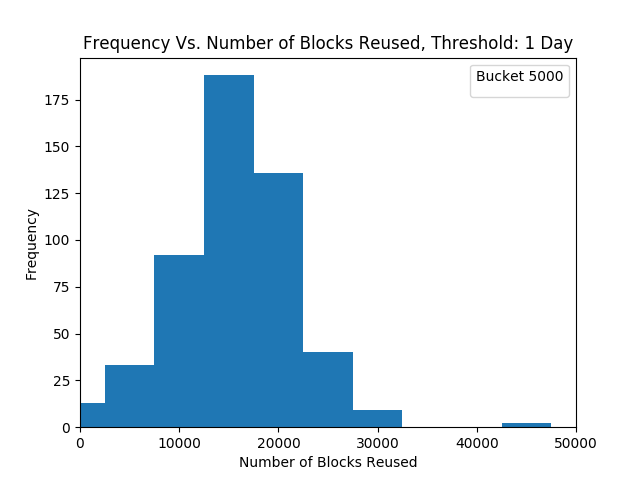

Empty Key:  245


No handles with labels found to put in legend.


Empty Key:  762


In [38]:
fig, ax = plt.subplots(1,1)
bucket = 5000
block_reuse_dict1 = countBlockReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Number of Blocks Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Blocks Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig("BlockReuseThreshold1.png")

<IPython.core.display.Javascript object>


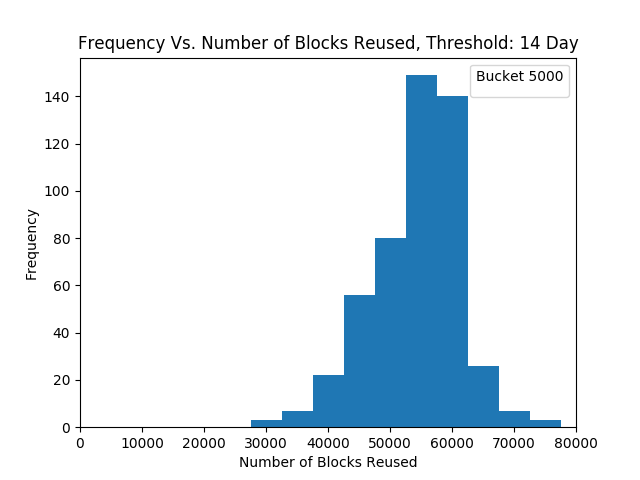

Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245


No handles with labels found to put in legend.


Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762


In [39]:
fig, ax = plt.subplots(1,1)
bucket = 5000
block_reuse_dict14 = countBlockReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Number of Blocks Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Blocks Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig("BlockReuseThreshold14.png")

<IPython.core.display.Javascript object>


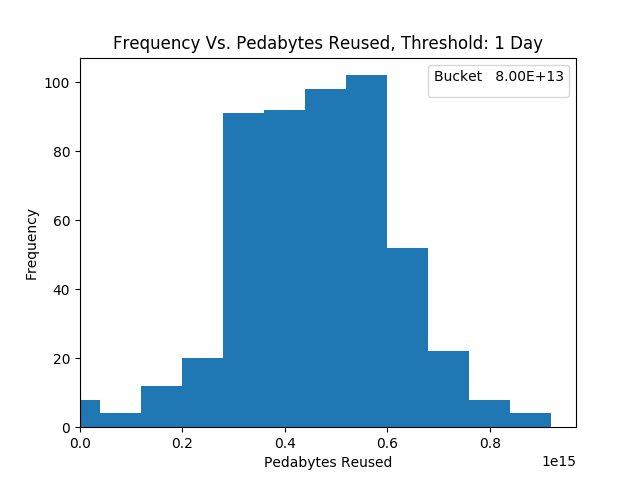

Empty Key:  245


No handles with labels found to put in legend.


Empty Key:  762


In [25]:
fig, ax = plt.subplots(1,1)
bucket = 8*1e13
block_reuse_dict1 = countByteReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Pedabytes Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(format(bucket, "10.2E")))
ax.set_ylabel('Frequency')
ax.set_xlabel('Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig("ByteReuseThreshold1.png")

<IPython.core.display.Javascript object>


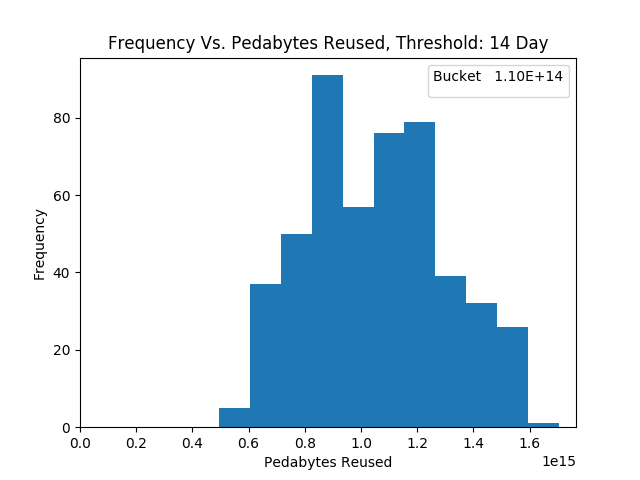

Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245


No handles with labels found to put in legend.


Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762


In [44]:
fig, ax = plt.subplots(1,1)
bucket = 12*1e13
block_reuse_dict14 = countByteReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Pedabytes Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(format(bucket, "10.2E")))
ax.set_ylabel('Frequency')
ax.set_xlabel('Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig("ByteReuseThreshold14.png")

<IPython.core.display.Javascript object>


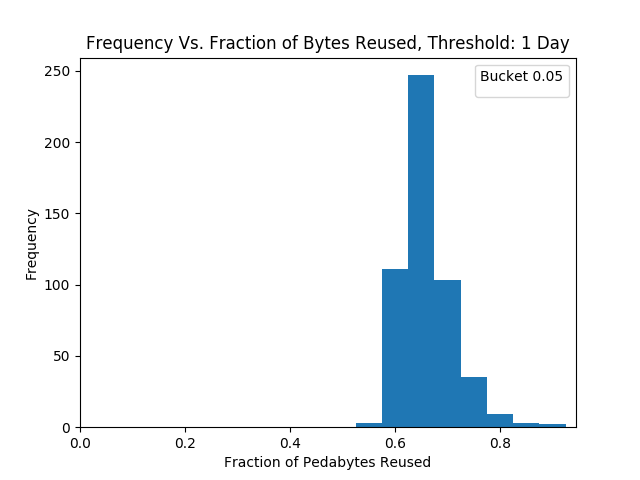

Empty Key:  245


No handles with labels found to put in legend.


Empty Key:  762


In [21]:
fig, ax = plt.subplots(1,1)
bucket = 0.05
block_reuse_dict1 = countByteFracReuseFreq(1, bucket)
ax.bar(list(block_reuse_dict1.keys()), list(block_reuse_dict1.values()), width=bucket)
ax.set_title('Frequency Vs. Fraction of Bytes Reused, Threshold: 1 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Fraction of Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig("ByteFracReuseThreshold1.png")

<IPython.core.display.Javascript object>


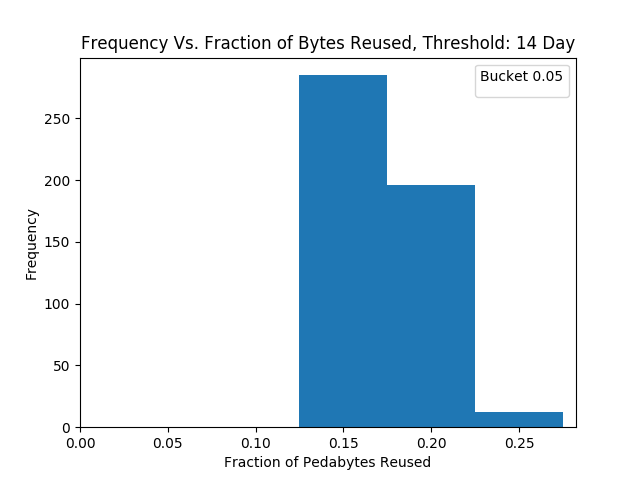

Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  245
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762


No handles with labels found to put in legend.


Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762
Empty Key:  762


In [22]:
fig, ax = plt.subplots(1,1)
bucket = 0.05
block_reuse_dict14 = countByteFracReuseFreq(14, bucket)
ax.bar(list(block_reuse_dict14.keys()), list(block_reuse_dict14.values()), width=bucket)
ax.set_title('Frequency Vs. Fraction of Bytes Reused, Threshold: 14 Day')
ax.legend(title='Bucket ' + str(bucket))
ax.set_ylabel('Frequency')
ax.set_xlabel('Fraction of Pedabytes Reused')
ax.set_ylim(0, None)
ax.set_xlim(0, None)
plt.savefig("ByteFracReuseThreshold14.png")

In [23]:
endTime = datetime.datetime.now()

In [24]:
timeDifference = endTime-startTime
print("Total Runtime:")
print(timeDifference)

Total Runtime:
0:20:25.865028
